In [412]:
#импорт библиотек
import pandas as pd
import numpy as np
import sklearn as skl
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RepeatedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from datetime import datetime

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [413]:
#отключение прерывания при ошибке
import warnings
warnings.filterwarnings('ignore')

In [414]:
matplotlib.rcParams.update({'font.size': 14})

In [415]:
#Пути к директориям и файлам
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'
TEST_DATASET_EXT_PATH = 'Evstaf`ev_predictions.csv'

In [416]:
#загрузка данных
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

In [417]:
#количество признаков различается на целевую переменную
train_df.shape[1] - 1 == test_df.shape[1]

True

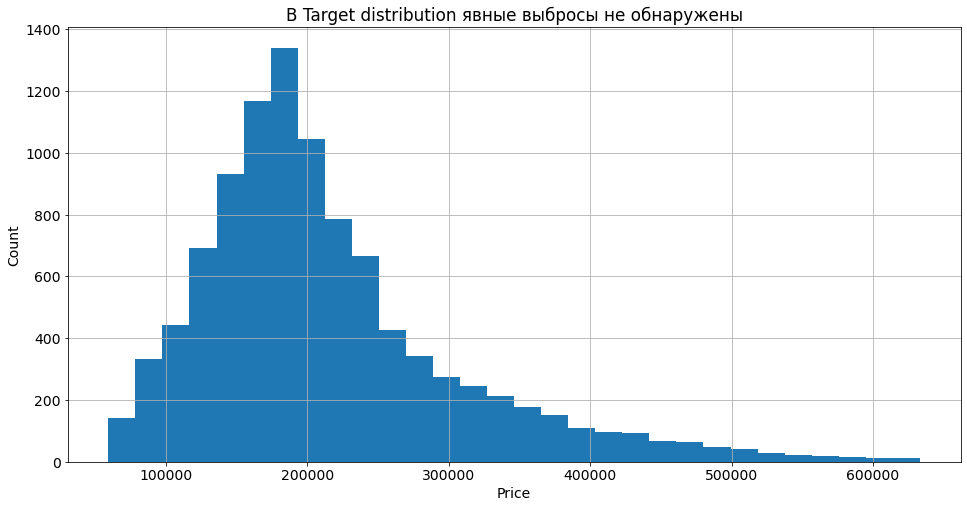

In [418]:
# просмотр выборки целевого признака на предмет явных выбросов
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('В Target distribution явные выбросы не обнаружены')
plt.show()

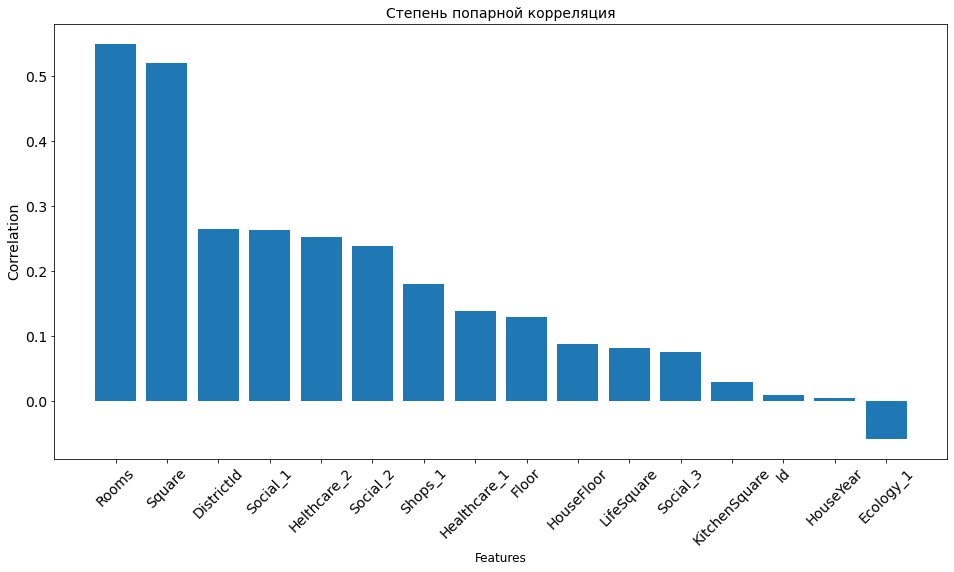

In [419]:
# Степень корреляции целевого признака с остальными
correlation = train_df.corrwith(train_df['Price']).sort_values(ascending=False)
correlation.drop('Price', inplace=True)
plt.figure(figsize = (16, 8))
plt.bar(correlation.index, correlation)
plt.xticks(rotation='45')
plt.xlabel('Features', fontsize=12)
plt.ylabel('Correlation', fontsize=14)
plt.title('Степень попарной корреляция', fontsize=14)
plt.show()

In [420]:
#список и тип данных признаков, для оценки необходимости предобработки
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [421]:
#предобработка признаков
# Id  и DistrictId переводить в str не обязательно, эти признаки не будут участвовать в обучении
class DataPreprocessor:
    def __init__(self):
        #
        self.medians = None
        self.binary_to_numbers = None
        self.square_max_value = None
        self.square_min_value = None
        self.life_square_min_value = None
        self.kitchen_square_max_value = None
        self.kitchen_square_min_value = None
        self.districts_healthcare = None
                
    def fit(self, df):
        # Медианы и квантили
        self.medians = df.median() # medians
        self.binary_to_numbers = {'A': 0, 'B': 1}
        self.square_max_value = np.quantile(df['Square'], q=0.99)
        self.square_min_value = np.quantile(df['Square'], q=0.01)
        self.life_square_min_value = np.quantile(df['LifeSquare'], q=0.02)
        self.kitchen_square_max_value = np.quantile(df['KitchenSquare'], q=0.99)
        self.kitchen_square_min_value = np.quantile(df['KitchenSquare'], q=0.01)
        self.districts_healthcare = df.groupby(['DistrictId'])['Healthcare_1'].agg('mean').to_dict()
        
    def transform(self, df):
        #Трансформация данных
            
        # Смена типа данных на binary Ecology_2, Ecology_3, Shops_2
        df.replace({'Ecology_2': self.binary_to_numbers}, inplace=True)
        df.replace({'Ecology_3': self.binary_to_numbers}, inplace=True)
        df.replace({'Shops_2': self.binary_to_numbers}, inplace=True)
        
        # Работа с выбросами HouseYear
        current_year = datetime.now().year
        df['HouseYear_outlier'] = 0
        df.loc[(df['HouseYear'] > current_year) | (df['HouseYear'] <0) | (train_df['HouseYear'] <1900), 'HouseYear_outlier'] = 1
        condition_year = (df['HouseYear_outlier'] == 1)
        df.loc[condition_year, 'HouseYear'] = self.medians.HouseYear
        
        #Работа с выбросами HouseFloor
        # HouseFloor < Floor и HouseFloor !=0 : перепутали местами; HouseFloor < Floor и HouseFloor ==0: нет данных по этажности
        df['HouseFloor&Floor_outlier'] = 0
        house_floor_condition = (df['HouseFloor'] < df['Floor'])
        house_floor_condition_z = ((df['HouseFloor'] < df['Floor']) & (df['HouseFloor'] == 0))
        house_floor_condition_nz = ((df['HouseFloor'] < df['Floor']) & (df['HouseFloor'] != 0))
        
        df.loc[house_floor_condition, 'HouseFloor&Floor_outlier'] = 1
        df.loc[house_floor_condition_z, 'HouseFloor'] = df.loc[house_floor_condition, 'Floor']
        df['HouseFloor'], df['Floor'] = np.where(house_floor_condition_nz,(df['Floor'],df['HouseFloor']),\
                                                                         (df['HouseFloor'],df['Floor']))
        
        # Square
        # LifeSquare > Square: перепутали местами
        df['LifeSquare&Square_outlier'] = 0
        condition_square = ((df['Square'] > self.square_max_value) | (df['Square'] < self.square_min_value))
        df.loc[condition_square, 'LifeSquare&Square_outlier'] = 1
        df.loc[(df['Square'] < df['LifeSquare']), 'LifeSquare&Square_outlier'] = 1
        df['Square'], df['LifeSquare'] = np.where(df['Square'] < df['LifeSquare'],(df['LifeSquare'],df['Square']),\
                                                                                  (df['Square'],df['LifeSquare']))
        df.loc[condition_square, 'Square'] = self.medians.Square
        
        # LifeSquare
        # Если меньше минимальной квантили: как разница Square - KithcenSquare
        df['LifeSquare_outlier'] = 0
        condition_ls = (df['LifeSquare'] < self.life_square_min_value)
        df.loc[condition_ls, 'LifeSquare_outlier'] = 1
        df.loc[condition_ls, 'LifeSquare'] = df.loc[condition_ls, ['Square']] - df.loc[condition_ls, ['KitchenSquare']]
        
        # LifeSquare fillna: для пропусков
        df['LifeSquare_outlier'] = df['LifeSquare'].isna() * 1
        df['LifeSquare'].fillna((self.medians.LifeSquare / self.medians.Rooms), inplace=True)
        
        # KitchenSquare
        # для выбросов: (Square - LifeSquare - 10% of Square)
        df['KitchenSquare_outlier'] = 0
        condition_kitchen_square = (df['KitchenSquare'] > self.kitchen_square_max_value) | (df['KitchenSquare']\
                                                                                < self.kitchen_square_min_value)
        df.loc[condition_kitchen_square, 'KitchenSquare'] = df.loc[condition_kitchen_square, 'Square']\
        - df.loc[condition_kitchen_square, 'LifeSquare']
        
        # Rooms
        # Для пропусков - median()         
        df['Rooms'].fillna(self.medians.Rooms, inplace=True) 
        
        # Healthcare
        # #заполнение пропусков через медиану средних Healthcare по группировке DistrictId     
        df.loc[df['Healthcare_1'].isna(), 'Healthcare_1'] = df['DistrictId'].map(self.districts_healthcare)
        df['Healthcare_1'].fillna(self.medians.Healthcare_1, inplace=True)       
        # Clip on upper quantille
        q_max = np.quantile(df['Healthcare_1'], q=0.9)
        df['Healthcare_1'].clip(upper=q_max, axis=0, inplace=True)
        
        # Необходимости в Id нет
        df.drop(['Id'], axis=1, inplace=True)
        
        # Для возможных неучтенных пропусков 
        df.fillna(self.medians, inplace=True)
        return df

In [422]:
class FeatureGenerator:
    def __init__(self):
        self.districts_median_year = None
        self.districts_density = None
        self.district_price_per_square = None
        self.year_price_per_square = None
        self.min_sq = None
        self.max_sq = None

        
    def fit(self, df):   
        self.min_sq = np.quantile(df['Square'], q=0.01)
        self.max_sq = np.quantile(df['Square'], q=0.99)
        
        self.districts_median_year = df.groupby(['DistrictId'])['HouseYear'].agg('median').to_dict()
        self.districts_density = df.groupby(['DistrictId'])['Square'].agg('median').to_dict()
        self.district_price_per_square = df.groupby(['DistrictId'])['Price'].agg('median') \
                                        / df.groupby(['DistrictId'])['Square'].agg('median')
        self.year_price_per_square = df.groupby(['HouseYear'])['Price'].agg('median') \
                                        / df.groupby(['HouseYear'])['Square'].agg('median')
    
    def new_features(self, df):
        # Средний (медиана) год постройки домов в District
        df['DistrictYear'] = df['DistrictId'].map(self.districts_median_year)
        # заполнение возможных пропусков
        self.median_district_year = df['DistrictYear'].median()
        df['DistrictYear'].fillna(self.median_district_year, inplace=True)


        # Среднее (медиана) значение площади квартир в District
        df['DistrictDensity'] = df['DistrictId'].map(self.districts_density)
        # заполнение возможных пропусков
        self.median_district_density = df['DistrictDensity'].median()
        df['DistrictDensity'].fillna(self.median_district_density, inplace=True)


        # Среднее значение (медиана) цены за кв.м. (спасибо преопдавателю Юлии)
        self.district_price_per_square.to_dict()
        df['DistrictPrice'] = df['DistrictId'].map(self.district_price_per_square)
        # заполнение возможных пропусков
        self.median_district_price_per_square = df['DistrictPrice'].median()
        df['DistrictPrice'].fillna(self.median_district_price_per_square, inplace=True)

        
        # Среднее значение (медиана) цены за кв.м. от года постройки
        self.year_price_per_square.to_dict()
        df['YearPrice'] = df['HouseYear'].map(self.year_price_per_square)
        # заполнение возможных пропусков
        self.median_year_price_per_square = df['YearPrice'].median()
        df['YearPrice'].fillna(self.median_year_price_per_square, inplace=True)
        
        
        # Floor category
        floor_bins = [0, 4, 7, 12, df['Floor'].max()]
        df['Floor_cat'] = pd.cut(df['Floor'], bins=floor_bins, labels=False)
        df['Floor_cat'].fillna(-1, inplace=True) 

        
        # Scale and merge Social
        scaler = RobustScaler()
        pca = PCA(n_components=1, random_state=42)
        social_scaled = pd.DataFrame(scaler.fit_transform(df[['Social_1', 'Social_2', 'Social_3']]))
        df['Social'] = pca.fit_transform(social_scaled)
        
        
        df.drop(['Ecology_2', 'Ecology_3', 'Shops_2', 'Helthcare_2', 'Floor',], axis=1, inplace=True)
        
        return df
    
    
    def drop_outliers(self, df):
        df = df.loc[(df['Square'] > self.min_sq) & (df['Square'] < self.max_sq)]
        return df

In [423]:
preprocessor = DataPreprocessor()
preprocessor.fit(train_df)
train_df = preprocessor.transform(train_df)
test_df = preprocessor.transform(test_df)

In [424]:
features_gen = FeatureGenerator()
features_gen.fit(train_df)
train_df = features_gen.new_features(train_df)
train_df = features_gen.drop_outliers(train_df)
test_df = features_gen.new_features(test_df)

In [425]:
y = pd.DataFrame(data=train_df['Price'])
train_df.drop('Price', axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=0.15, random_state=100)

In [426]:
#Gradient Boosting Regressor model fit and predict for train dataset

In [427]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=6,
                                     min_samples_leaf=50,
                                     random_state=42,  
                                     n_estimators=2250, 
                                     max_features='sqrt', 
                                     loss='huber', 
                                     learning_rate=0.025)

gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_test)
print(r2(y_train, y_train_preds))
print(r2(y_test, y_test_preds))

0.8473245475589447
0.8028022335125169


In [428]:
#Feature importance

In [429]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances

,feature_name,importance
2,Square,0.215106
20,DistrictPrice,0.179742
1,Rooms,0.144339
3,LifeSquare,0.085773
8,Social_1,0.040970
21,YearPrice,0.037927
10,Social_3,0.036545
4,KitchenSquare,0.033240
9,Social_2,0.032799
23,Social,0.031564


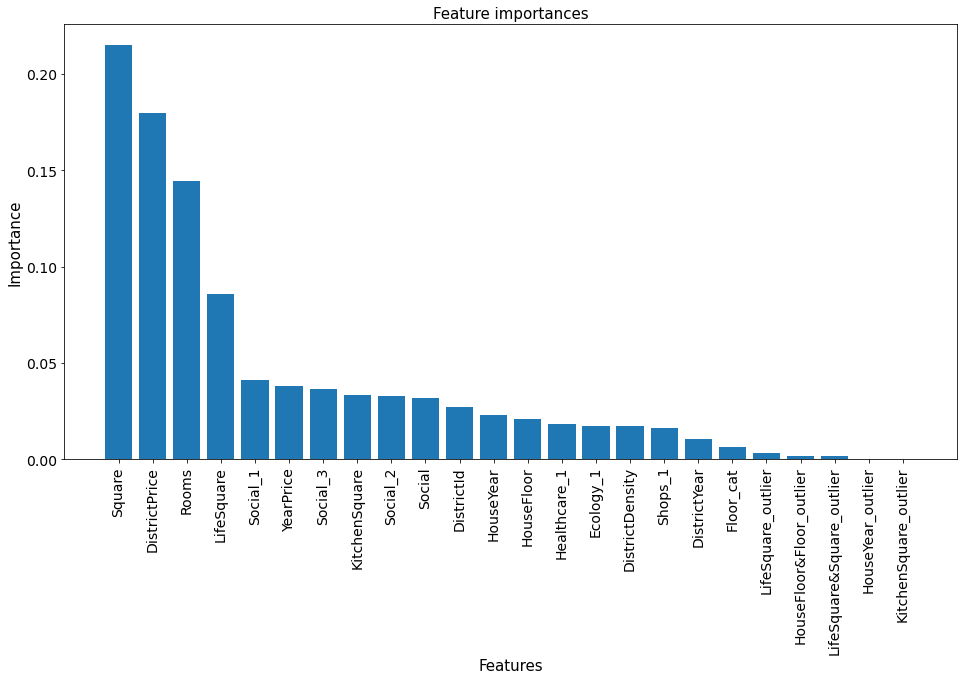

In [430]:
plt.figure(figsize = (16, 8))
plt.bar(feature_importances['feature_name'], feature_importances['importance'])
plt.xticks(rotation='90')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Importance', fontsize=15)
plt.title('Feature importances', fontsize=15)
plt.show()

In [431]:
test_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,...,HouseFloor&Floor_outlier,LifeSquare&Square_outlier,LifeSquare_outlier,KitchenSquare_outlier,DistrictYear,DistrictDensity,DistrictPrice,YearPrice,Floor_cat,Social
0,44,1.0,36.847630,19.094182,5.0,9.0,1970.0,0.036122,24,4378,...,0,0,0,0,1977.0,47.650564,4368.562488,4353.459766,1,-1.654285
1,62,1.0,42.568133,42.493907,10.0,17.0,2017.0,0.072158,2,629,...,0,1,0,0,1977.0,54.626757,2966.811236,3123.079920,1,-1.462656
2,27,2.0,59.463678,16.390630,9.0,19.0,1977.0,0.211401,9,1892,...,0,0,1,0,1977.0,53.953960,2709.188229,2967.348656,3,-1.659865
3,23,3.0,49.646030,33.893825,6.0,2.0,1965.0,0.014073,2,475,...,0,0,0,0,1977.0,53.477290,2127.810933,4235.182104,0,-1.662911
4,74,1.0,53.837056,16.390630,1.0,17.0,1977.0,0.309479,35,7715,...,0,0,1,0,1977.0,55.992116,3493.544704,2967.348656,2,-0.847631


In [432]:
submit = pd.read_csv('C:\\Users\\Al\\PythonForDS\\sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [433]:
predictions = gb_model.predict(test_df)
predictions

array([159314.28094233, 120625.92162573, 142637.60479546, ...,
       152029.8930526 , 194870.55592721, 273880.09874926])

In [434]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,159314.280942
1,5925,120625.921626
2,960,142637.604795
3,3848,109412.842606
4,746,177959.090034


In [435]:
#убедимся, что ничего не потеряли
submit.shape

(5000, 2)

In [436]:
submit.to_csv(TEST_DATASET_EXT_PATH, index=False)